#Lectura y procesamiento de los resultados de los mejores modelos ELM

En el presente archivo se leen los archivos excel que contienen resumenes de los modelos generados con las grillas de ELM. Se procesa dicha información para encontrar los mejores modelos.

In [1]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/Universidad/2020/Tesis_final/Codigos/leer_procesar_modelos_NARMAX/elm/

/content/gdrive/MyDrive/Universidad/2020/Tesis_final/Codigos/leer_procesar_modelos_NARMAX/elm


In [3]:
ls

grilla_ELM_NARMAX_16STEPS.xlsx  grilla_ELM_NARMAX_8STEPS.xlsx
grilla_ELM_NARMAX_2STEPS.xlsx   leer_procesar_modelos_ELM_NARMAX.ipynb
grilla_ELM_NARMAX_4STEPS.xlsx


In [4]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

summaryModelsELM2S = pd.read_excel('grilla_ELM_NARMAX_2STEPS.xlsx', header=0)
summaryModelsELM4S = pd.read_excel('grilla_ELM_NARMAX_4STEPS.xlsx', header=0)
summaryModelsELM8S = pd.read_excel('grilla_ELM_NARMAX_8STEPS.xlsx', header=0)
summaryModelsELM16S = pd.read_excel('grilla_ELM_NARMAX_16STEPS.xlsx', header=0)

grilla_ELM_NARMAX_AQP = pd.concat([summaryModelsELM2S, summaryModelsELM4S], ignore_index=True)
grilla_ELM_NARMAX_AQP = pd.concat([grilla_ELM_NARMAX_AQP, summaryModelsELM8S], ignore_index=True)
grilla_ELM_NARMAX_AQP = pd.concat([grilla_ELM_NARMAX_AQP, summaryModelsELM16S], ignore_index=True)

grilla_ELM_NARMAX_AQP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MAE                     56 non-null     float64
 1   delayedSteps            56 non-null     int64  
 2   nameModel               56 non-null     object 
 3   nameConfiguration       56 non-null     object 
 4   timeTrain (in seconds)  56 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ KB


##La cantidad de modelos generados para el ELM NARX de AQP fue de 56

In [5]:
rslt_df = grilla_ELM_NARMAX_AQP.sort_values('MAE')
total = grilla_ELM_NARMAX_AQP['timeTrain (in seconds)'].sum()
print("Total time: " + str(total))
grilla_ELM_NARMAX_AQP.describe()

Total time: 2011.17


MAE  delayedSteps  timeTrain (in seconds)
count  56.000000     56.000000               56.000000
mean    0.441302      7.500000               35.913750
std     0.162195      5.410428               69.162849
min     0.307393      2.000000                0.020000
25%     0.337165      3.500000                0.227500
50%     0.379869      6.000000                3.480000
75%     0.478759     10.000000               26.915000
max     1.043484     16.000000              214.370000

##La cantidad de segundos totales para ejecutar la grilla es aproximadamente 2011, lo que equivale a media hora aproximadamente. Además se tienen las estadisticas resumen.

In [6]:
rslt_df.iloc[:10,:]

MAE  ...  timeTrain (in seconds)
44  0.307393  ...                    0.24
43  0.308954  ...                    0.03
42  0.309930  ...                    0.04
47  0.310099  ...                    0.49
45  0.318893  ...                    0.23
28  0.324199  ...                    0.15
2   0.325214  ...                    0.12
17  0.326969  ...                    0.22
29  0.327581  ...                    0.02
15  0.327913  ...                    0.02

[10 rows x 5 columns]

In [10]:
rslt_df.iloc[0,:]

MAE                                                      0.307393
delayedSteps                                                   16
nameModel                     results/ELM_752_1_50_mse_16S.joblib
nameConfiguration         results/ELM_752_1_50_mse_16S_config.npy
timeTrain (in seconds)                                       0.24
Name: 44, dtype: object

##Por principio de parsimonia, se decide trabajar con un modelo que genera un MAE de 0.32, pero que tiene pocos retardos, especificamente 2 retardos.

In [11]:
bestModel = rslt_df.iloc[0,:]
print(bestModel)

MAE                                                      0.307393
delayedSteps                                                   16
nameModel                     results/ELM_752_1_50_mse_16S.joblib
nameConfiguration         results/ELM_752_1_50_mse_16S_config.npy
timeTrain (in seconds)                                       0.24
Name: 44, dtype: object


In [12]:
import time


def _mean_squared_error(y, pred):
    return 0.5 * np.mean((y - pred) ** 2)


def _mean_abs_error(y, pred):
    return np.mean(np.abs(y - pred))


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def _identity(x):
    return x



def getActivation(name):
    return {
        'sigmoid': _sigmoid
    }[name]


def getLoss(name):
    return {
        'mse': _mean_squared_error,
        'mae': _mean_abs_error
    }[name]


class ELM:
    def __init__(self, num_input_nodes, num_hidden_units, num_out_units, activation='sigmoid',
                 loss='mse', beta_init=None, w_init=None, bias_init=None):
        self._num_input_nodes = num_input_nodes
        self._num_hidden_units = num_hidden_units
        self._num_out_units = num_out_units

        self._activation = getActivation(activation)
        self._loss = getLoss(loss)

        if isinstance(beta_init, np.ndarray):
            self._beta = beta_init
        else:
            self._beta = np.random.uniform(-1., 1., size=(self._num_hidden_units, self._num_out_units))

        if isinstance(w_init, np.ndarray):
            self._w = w_init
        else:
            self._w = np.random.uniform(-1, 1, size=(self._num_input_nodes, self._num_hidden_units))

        if isinstance(bias_init, np.ndarray):
            self._bias = bias_init
        else:
            self._bias = np.zeros(shape=(self._num_hidden_units,))

        #print('Bias shape:', self._bias.shape)
        #print('W shape:', self._w.shape)
        #print('Beta shape:', self._beta.shape)

    def fit(self, X, Y, display_time=False):
        H = self._activation(X.dot(self._w) + self._bias)

        # Moore–Penrose pseudo inverse
        if display_time:
            start = time.time()
        H_pinv = np.linalg.pinv(H)
        if display_time:
            stop = time.time()
            print(f'Train time: {stop-start}')

        self._beta = H_pinv.dot(Y)

        # print('Fit Beta shape:', self._beta.shape)

    def __call__(self, X):
        H = self._activation(X.dot(self._w) + self._bias)
        return H.dot(self._beta)

    def evaluate(self, X, Y):
        pred = self(X)

        # Loss (base on model setting)
        loss = self._loss(Y, pred)

        # Accuracy
        #acc = np.sum(np.argmax(pred, axis=-1) == np.argmax(Y, axis=-1)) / len(Y)

        # Unweighted Average Recall
        # TODO

        #return loss, acc, pred
        return loss, pred

In [14]:
#para recuperar configDict
config=np.load('ELM_752_1_50_mse_16S_config.npy',allow_pickle='TRUE').item()
print(config)

#Para cargar modelo:
saved_model = load('ELM_752_1_50_mse_16S.joblib') 

{'nInputs': 752, 'nOutputs': 1, 'nHiddenUnits': 50, 'Loss': 'mse', 'Delays': 16, 'PredictionHorizon': 24}


In [15]:
def cargarData1():
  trainDFScaled = pd.read_csv('data/dataTrainNarmaxScaledELM.csv', header=0)
  testDFScaled = pd.read_csv('data/dataTestNarmaxScaledELM.csv', header=0)
  trainDF = pd.read_csv('data/dataTrainNarmaxELM.csv', header=0)
  testDF = pd.read_csv('data/dataTestNarmaxELM.csv', header=0)
  return trainDFScaled, testDFScaled, trainDF, testDF

def generateSupervisedData(data, delays, predictionHorizon, columnTarget = 45):
  cont = 0
  X = list()
  y = list()

  #Se va a iterar para cada fragmento de datos
  values = data.values
  chunk_ids = np.unique(values[:, 0])
  for chunk_id in chunk_ids:
    rows = data.loc[(data['chunkID'] == chunk_id)]
    #print(rows)
    cantidadFilas = rows.shape[0]
    indexAux = 0
    indexTarget = 0
    for _, row in rows.iterrows():
      end_row = indexAux + delays
      indexTarget = end_row - 1 + predictionHorizon
      if indexTarget <= cantidadFilas-1:
        salidaAux = rows.iloc[indexTarget, columnTarget]
        xAux = rows.iloc[indexAux:end_row, :].values
        #print(xAux.shape)
        #print(xAux)
        X.append(xAux)
        y.append(salidaAux)
        #print(salidaAux)
      indexAux = indexAux + 1
    cont = cont + 1
  X = np.array(X)
  y = np.array(y)
  return X, y

def generateFinalData(delays, predictionHorizon, trainDFScaled, testDFScaled, trainDF, testDF):
  trainXScaled, trainYScaled = generateSupervisedData(trainDFScaled, delays, predictionHorizon)
  testXScaled, testYScaled = generateSupervisedData(testDFScaled, delays, predictionHorizon)
  trainX, trainY = generateSupervisedData(trainDF, delays, predictionHorizon)
  testX, testY = generateSupervisedData(testDF, delays, predictionHorizon)
  #print("trainXScaled.shape: ", str(trainXScaled.shape))
  #print("trainYScaled.shape: ", str(trainYScaled.shape))
  #print("testXScaled.shape: ", str(testXScaled.shape))
  #print("testYScaled.shape: ", str(testYScaled.shape))
  #print("trainX.shape: ", str(trainX.shape))
  #print("trainY.shape: ", str(trainY.shape))
  #print("testX.shape: ", str(testX.shape))
  #print("testY.shape: ", str(testY.shape))
  return trainXScaled, trainY, testXScaled, testY


def reshapeXdata(trainXScaled, testXScaled):
  #reshape data
  trainXScaled = trainXScaled.reshape((trainXScaled.shape[0],trainXScaled.shape[1]*trainXScaled.shape[2]))
  #print("trainXScaled.shape: ", str(trainXScaled.shape))
  testXScaled = testXScaled.reshape((testXScaled.shape[0],testXScaled.shape[1]*testXScaled.shape[2]))
  #print("testXScaled.shape: ", str(testXScaled.shape))
  return trainXScaled, testXScaled

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
	# calculate abs difference
	return abs(actual - predicted)

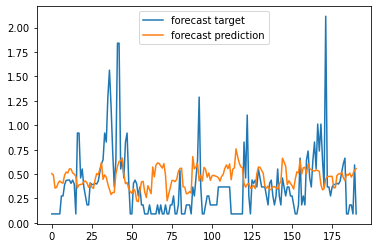

In [17]:
trainDFScaled, testDFScaled, trainDF, testDF = cargarData1()
trainXScaled, trainY, testXScaled, testY = generateFinalData(bestModel['delayedSteps'], 24, trainDFScaled, testDFScaled, trainDF, testDF)
trainXScaled, testXScaled = reshapeXdata(trainXScaled, testXScaled)
validation_target = testY[:191]
val_loss, validation_predictions = saved_model.evaluate(testXScaled[:191,:], validation_target)

fig, ax = plt.subplots(1, 1)
ax.plot(validation_target, label='forecast target')
ax.plot(validation_predictions, label='forecast prediction')
ax.legend()
